## Twitter Sentiment Analysis:
The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

## Evaluation Metric:
The metric used for evaluating the performance of classification model would be F1-Score.
The metric can be understood as -

* True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.
* True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.
* False Positives (FP) – When actual class is no and predicted class is yes.
* False Negatives (FN) – When actual class is yes but predicted class in no.

- Precision = TP/TP+FP
- Recall = TP/TP+FN

F1 Score = 2*(Recall * Precision) / (Recall + Precision)
F1 is usually more useful than accuracy, especially if for an uneven class distribution.


## Advantages:
* System will allow user to input a keyword and search for trending tweet.
* System will provide accurate results based on user inputted keyword.

## Disdvantages:
* It will provide inaccurate results if keyword not entered correctly/properly.

In [1]:
# Importing required packages
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline
#from google.colab import files
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\com\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Reading Data:

In [2]:
train = pd.read_csv("train_tweets.csv")
test = pd.read_csv("test_tweets.csv")

In [3]:
print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


### So We have 31962 tweets in the train set and 31962 tweets in the test set

In [4]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


# EDA

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [7]:
train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [9]:
# Checking for NULL/missing values
train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

## There are no null Values in the train set

In [10]:
test.isnull().sum()

id       0
tweet    0
dtype: int64

## There are no null Values in the test set

In [11]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# DATA INSPECTION

In [12]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

### Comment: In the train dataset, we have 2,242 (7%) tweets labeled as racist or sexist, and 29,720 (93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.

<AxesSubplot:xlabel='label', ylabel='count'>

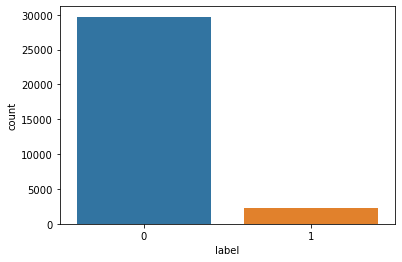

In [13]:
sns.countplot(train["label"])

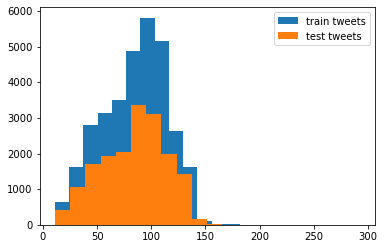

In [14]:
train_len=train["tweet"].str.len()
test_len=test["tweet"].str.len()
plt.hist(train_len,bins=20,label="train tweets")
plt.hist(test_len,bins=20,label="test tweets")
plt.legend()
plt.show()

In [15]:
# Class count
count_class_0 ,count_class_1 = train.label.value_counts()

# Divide by class
class_0 = train[train.label == 0]
class_1 =train[train.label == 1]
class_0_under = class_0.sample(count_class_1)
train_under = pd.concat([class_0_under, class_1], axis=0)

print('Random under-sampling:')
#print(df_test_under.sentiment.value_counts())
print(train_under.label.value_counts())
print(train_under.shape)

Random under-sampling:
1    2242
0    2242
Name: label, dtype: int64
(4484, 3)


In [16]:
class_1_over = class_1.sample(count_class_0, replace=True)
train_over = pd.concat([class_0, class_1_over ], axis=0)

print('Random under-sampling:')
#print(df_test_under.sentiment.value_counts())
print(train_over.label.value_counts())
print(train_over.shape)

Random under-sampling:
1    29720
0    29720
Name: label, dtype: int64
(59440, 3)


In [17]:
train=train_over.reset_index()
combi=train.append(test,ignore_index=True)
combi.shape

(76637, 4)

In [18]:
combi.head()

,index,id,label,tweet
0,0.0,1,0.0,@user when a father is dysfunctional and is s...
1,1.0,2,0.0,@user @user thanks for #lyft credit i can't us...
2,2.0,3,0.0,bihday your majesty
3,3.0,4,0.0,#model i love u take with u all the time in ...
4,4.0,5,0.0,factsguide: society now #motivation


In [19]:
#remove unwanted text patterns from the tweets.
def remove_pattern(input_txt,pattern):
    r=re.findall(pattern,input_txt)
    for i in r:
        input_txt=re.sub(i,' ',input_txt)
    return input_txt

In [20]:
#1-Removing Twitter Handles (@user)
combi["tidy_tweet"]=np.vectorize(remove_pattern)(combi['tweet'],'@[\w]*')  
combi.head()

,index,id,label,tweet,tidy_tweet
0,0.0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so se...
1,1.0,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause ...
2,2.0,3,0.0,bihday your majesty,bihday your majesty
3,3.0,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,4.0,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [21]:
#2-Removing Punctuations, Numbers, and Special Characters-
#“[^a-zA-Z#]” means anything except alphabets and ‘#’.
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") 
combi.head()

,index,id,label,tweet,tidy_tweet
0,0.0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so se...
1,1.0,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause ...
2,2.0,3,0.0,bihday your majesty,bihday your majesty
3,3.0,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,4.0,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [22]:
#3-Removing Short Words-words having length 3 or less like “hmm”, “oh”
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,index,id,label,tweet,tidy_tweet
0,0.0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,1.0,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,2.0,3,0.0,bihday your majesty,bihday your majesty
3,3.0,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,4.0,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [23]:
#4-Text Normalization-use nltk’s PorterStemmer() function to normalize the 
#tweets. But before that we will have to tokenize the tweets. 
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [24]:
#Now we can normalize the tokenized tweets.
from nltk.stem.porter import *
stemmer=PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])   #stemming

In [25]:
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [26]:
#Now let’s stitch these tokens back together. It can easily be done using 
#nltk’s MosesDetokenizer function.
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['tidy_tweet'] = tokenized_tweet

In [27]:
tokenized_tweet.head()

0    when father dysfunct selfish drag kid into dys...
1    thank #lyft credit caus they offer wheelchair ...
2                                  bihday your majesti
3                           #model love take with time
4                             factsguid societi #motiv
Name: tidy_tweet, dtype: object

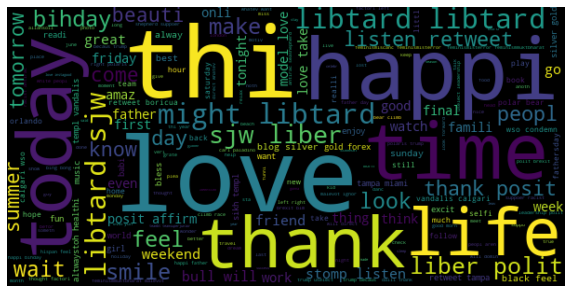

In [28]:
#A) Understanding the common words used in the tweets: WordCloud
from wordcloud import WordCloud
all_words = ' '.join([text for text in combi['tidy_tweet']])
wordcloud = WordCloud(width=600,height=300,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Comment: We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

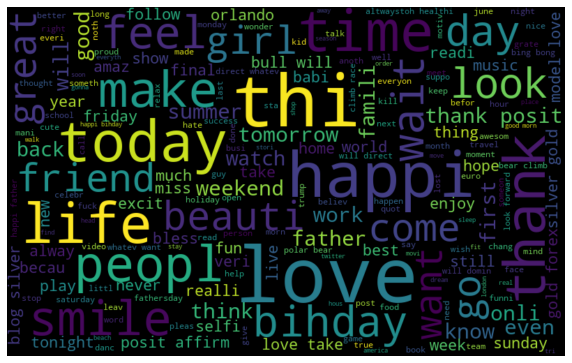

In [29]:
#B) Words in non racist/sexist tweets
normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])
wordcloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Comment: Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

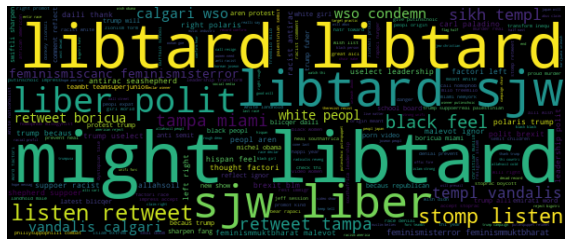

In [30]:
#C) Racist/Sexist Tweets
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=600,height=250,random_state=21,max_font_size=100).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Comment: As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on

In [31]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags=[]
    for i in x:
        ht=re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

In [32]:
# extracting hashtags from non racist/sexist tweets 
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])
# extracting hashtags from racist/sexist tweets 
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

In [33]:
# unnesting list 
HT_regular = sum(HT_regular,[]) 
HT_negative = sum(HT_negative,[])

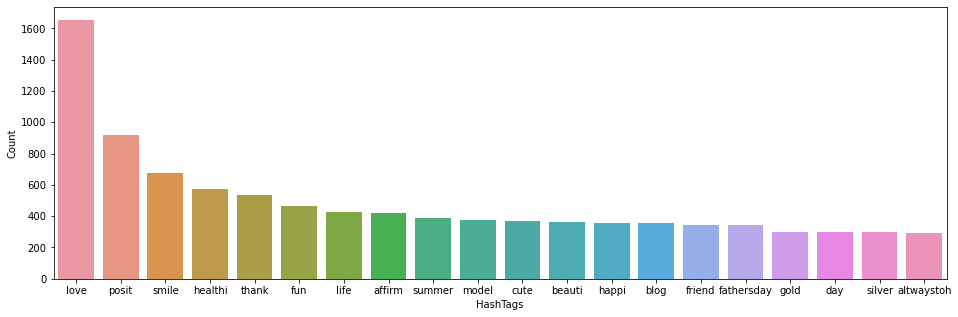

In [34]:
#Non-Racist/Sexist Tweets
a=nltk.FreqDist(HT_regular)
d=pd.DataFrame({'HashTags': list(a.keys()), 'Count' : list(a.values())})
# selecting top 20 most frequent hashtags 
d=d.nlargest(columns='Count',n=20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d , x='HashTags' ,y='Count')
ax.set(ylabel='Count')
plt.show()

### Comment: All these hashtags are positive

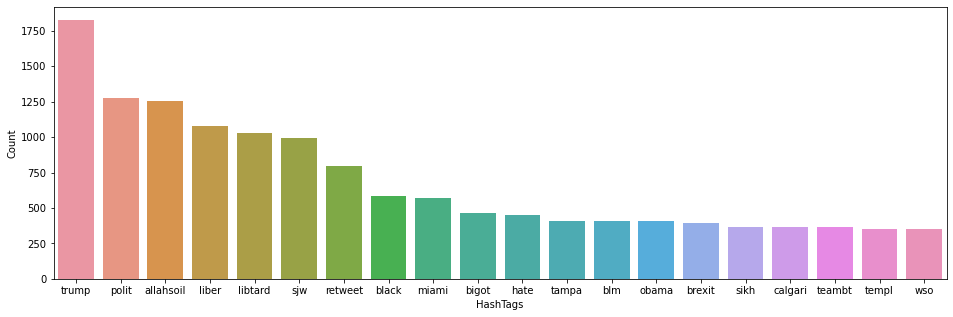

In [35]:
#Racist/Sexist Tweets
b=nltk.FreqDist(HT_negative)
e=pd.DataFrame({'HashTags': list(b.keys()),'Count': list(b.values())})
# selecting top 20 most frequent hashtags 
e = e.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax=sns.barplot(data=e,x="HashTags",y="Count")
ax.set(ylabel='Count')
plt.show()


### Comment: As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.


# <font color=purple > Bag-of-Words Features
To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag of Words, TF-IDF, and Word Embeddings.
I have used Bag of Words technique:

In [36]:
combi.sample(10)

,index,id,label,tweet,tidy_tweet
30877,28500.0,28501,1.0,@user #feminismiscancer #feminismisterrorism #...,#feminismiscanc #feminismisterror #feminismmuk...
75135,NaN,47658,NaN,#national iced tea day!!! ó¾ó¾§ó¾¬ we a...,#nation ice #celebr offer #delici blend tea
65633,NaN,38156,NaN,pll has changed my life. cannot wait for seaso...,chang life cannot wait season
12514,13451.0,13452,0.0,#sunday everyone #enjoying #fashion #fashion...,#sunday everyon #enjoy #fashion #fashionconsul...
14966,16087.0,16088,0.0,lol now you know how i feel :(,know feel
7002,7528.0,7529,0.0,#saysomething bull up: you will dominate you...,#saysometh bull will domin your bull will dire...
74117,NaN,46640,NaN,i love #abrahamhicks and #lawofattraction !! ...,love #abrahamhick #lawofattract #healthi #heal...
31556,7638.0,7639,1.0,president #woodrowwilson held a private screen...,presid #woodrowwilson held privat screen griff...
56330,8857.0,8858,1.0,are you #black &amp; feel like â¦ are stompin...,#black feel like stomp listen #retweet #tampa ...
12314,13239.0,13240,0.0,at the movies! fun! #marriedlife #hubbinsinthe...,movi #marriedlif #hubbinsinthewild #love


In [37]:
combi['tidy_tweet'].head()

0    when father dysfunct selfish drag kid into dys...
1    thank #lyft credit caus they offer wheelchair ...
2                                  bihday your majesti
3                           #model love take with time
4                             factsguid societi #motiv
Name: tidy_tweet, dtype: object

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer=CountVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
bow2 = bow_vectorizer.fit(combi['tidy_tweet'])
bow = bow_vectorizer.transform(combi['tidy_tweet'])
bow.shape

(76637, 1000)

##  *train_test_split 

In [40]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score

In [41]:
#Bag-of-Words Features
train_bow = bow[:train.shape[0],:] 
test_bow = bow[train.shape[0]:,:] 
xtrain_bow, xtest_bow, ytrain, ytest = train_test_split(train_bow, train['label'], random_state=2,test_size=0.3) 

In [42]:
print(train_bow.shape)
print(test_bow.shape)

(59440, 1000)
(17197, 1000)


In [43]:
print(xtrain_bow.shape)
print(ytrain.shape)
print(xtest_bow.shape)
print( ytest.shape)

(41608, 1000)
(41608,)
(17832, 1000)
(17832,)


##  *logistic regression:

In [44]:
#Bag-of-Words Features
from sklearn.linear_model import LogisticRegression 
lreg = LogisticRegression() 
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xtest_bow) # predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 
print(np.around(f1_score(ytest, prediction_int),4))
#Now let’s make predictions for the test dataset and create a submission file.
test_pred = lreg.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3 
test_pred_int = test_pred_int.astype(np.int) 
test['label'] = test_pred_int 
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

0.8888


## *Random Forest:

In [45]:
from sklearn.ensemble import RandomForestClassifier
#Bag-of-Words Features
rf = RandomForestClassifier(random_state=11).fit(xtrain_bow, ytrain) 
prediction = rf.predict(xtest_bow) 
print(np.around(f1_score(ytest, prediction),4)) 

0.959


## *xgboost Classifier:

In [46]:
print(type(xtest_bow))

<class 'scipy.sparse.csr.csr_matrix'>


In [49]:
from xgboost import XGBClassifier
#Bag-of-Words Features
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain) 
prediction = xgb_model.predict(xtest_bow) 
print(np.around(f1_score(ytest, prediction),4)) 
test_pred = xgb_model.predict(test_bow) 
test['label'] = test_pred 
submission = test[['id','label']] 
submission.to_csv('sub_xgb_bow.csv', index=False)

0.9531


## GUI for the twitter sentiment analysis:

In [50]:
import pickle
import joblib
import tkinter as tk
from tkinter import *

In [51]:
pickle. dump(bow2, open("pim.pickle.dat", "wb"))

In [52]:
pickle.dump(xgb_model, open("pima.pickle.dat", "wb"))

In [56]:
from tkinter import*
from PIL import ImageTk, Image
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pickle
root=Tk()
root.geometry("550x550")
root.configure(background="light blue")

def model(tweet):
    #Bag-of-Words Features
    bow4 = pickle.load(open("pim.pickle.dat", "rb"))
    bow3 = bow4.transform([tweet])

    loaded_model = pickle.load(open("pima.pickle.dat", "rb"))
    prediction = loaded_model.predict(bow3)
    if prediction == [0]:
        notif1.configure(text="The tweet is not racist/sexist")
    else:
        notif1.configure(text="The tweet is racist/sexist")
#Exit App
def exit_app():
    root.destroy()        
#IMG=ImageTk.PhotoImage(Image.open("tsa image.png"))
#Label(root, image =IMG )
#Head1 = Label(root, text="", font=('Helvetica',24,"bold")).pack()
Head2 = Label(root,text="Twitter Sentiment Analysis",font=('Helvetica',24,'bold'),relief="solid").pack(pady=(10,0))

Tweet = Label(root,text="Pass the Tweet",font=('Helvetica',15,'bold'),bg="White",relief="solid",width=18).pack(pady=(30,0))
#Label(root,text="Predicted result is",font=('Helvetica',10,'bold'),bg="light pink",relief="solid",width=15).place(x=40,y=130)
tweet_input = Entry(root,bd=2,width="35",font=("Arial sans MS",14))
    
but = Button(root,text="Prediction",width="20", height="2",command=lambda: model(tweet_input.get()))
button_exit = Button(root, text = "Exit", width="10", height="1", command = exit_app) 
notif1 = Label(root, text="",font=("Arial sans MS",14,"bold"))

tweet_input.pack()
but.pack(pady="50")
button_exit.pack(pady="40")
notif1.place(x=150,y=280)
#notif1.pack(pady=(20,0))
root.resizable(0,0)
root.mainloop()